# SAT Scores and the Factors that Affect Them

## Introduction

The [Scholastic Aptitude Test, or SAT](https://en.wikipedia.org/wiki/SAT), is an exam that U.S. high school students take before applying to college. Colleges take the test scores into account when deciding who to admit, so it's fairly important to perform well on it. The test consists of three sections, each of which has 800 possible points. The combined score is out of 2,400 possible points.Organizations often rank high schools by their average SAT scores. The scores are also considered a measure of overall school district quality.

There is controversy around this test (and other standardized tests) though: are they unfair to certain groups?

In this study we will investigate correlations between SAT scores and demographics like race, gender, income, and more.

### Data
We will make us of data that is published by the City of New York. This includes SAT scores, demographic information and other data that is useful for our study. Here are the links to all of the data sets we'll be using:

* [SAT scores by school](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4): SAT scores for each high school in New York City
* [School attendance](https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt): attendance information for each school in New York City
* [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3): information on class size for each school
* [AP test results](https://data.cityofnewyork.us/Education/2010-AP-College-Board-School-Level-Results/itfs-ms3e): Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
* [Graduation outcomes](https://data.cityofnewyork.us/Education/2005-2010-Graduation-Outcomes-School-Level/vh2h-md7a): The percentage of students who graduated, and other outcome information
* [Demographics](https://data.cityofnewyork.us/Education/2006-2012-School-Demographics-and-Accountability-S/ihfw-zy9j): Demographic information for each school
* [School survey](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8): Surveys of parents, teachers, and students at each school

### Contents
The remainder of the notebook contains the following sections:

* Data preparations and cleaning
* Overview of the data
* Data analysis and visualization
* SAT scores per boro and per district
* Wrap-up and conclusions

### Data preparations and cleaning
In this section, we will first read in all the data, and do necessary data cleaning. Since all datasets are interrelated, we will combine them into a single dataset, that we can next use to find correlations.

## Read in the data

In [50]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [51]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [52]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [53]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [54]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [55]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [56]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [57]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [58]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.987
SAT Math Avg. Score                     0.973
SAT Writing Avg. Score                  0.988
sat_score                               1.000
AP Test Takers                          0.523
Total Exams Taken                       0.514
Number of Exams with scores 3 4 or 5    0.463
Total Cohort                            0.325
CSD                                     0.043
NUMBER OF STUDENTS / SEATS FILLED       0.395
NUMBER OF SECTIONS                      0.363
AVERAGE CLASS SIZE                      0.381
SIZE OF SMALLEST CLASS                  0.250
SIZE OF LARGEST CLASS                   0.314
SCHOOLWIDE PUPIL-TEACHER RATIO            NaN
schoolyear                                NaN
fl_percent                                NaN
frl_percent                            -0.722
total_enrollment                        0.368
ell_num                                -0.154
ell_percent                            -0.399
sped_num                          

## Overview of the data
Before we continue with our analysis and visualization, let's first take a look at the `combined` dataframe and the correlation table that we have created in the previous step.

In [59]:
# Check the size of our dataframe
print ('Nr of columns: ', combined.shape[1])
print ('Nr of rows: ', combined.shape[0])

Nr of columns:  160
Nr of rows:  363


So we have data for 363 schools, and not less than 161 pieces of info for each of them. Let's take a look at a sample.

In [60]:
# Show a sample of the data, for all columns in our dataframe
pd.set_option("display.max_columns", None)
# For all floats, show one decimal
pd.options.display.float_format = '{:.1f}'.format
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Demographic,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,Advanced Regents - n,Advanced Regents - % of cohort,Advanced Regents - % of grads,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,grade3,grade4,grade5,grade6,grade7,grade8,grade9,grade10,grade11,grade12,ell_num,ell_percent,sped_num,sped_percent,ctt_num,selfcontained_num,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,saf_t_11,com_t_11,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11,dbn,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,bus,subway,primary_address_line_1,city,state_code,zip,website,total_students,campus_name,school_type,overview_paragraph,program_highlights,language_classes,advancedplacement_courses,online_ap_courses,online_language_courses,extracurricular_activities,psal_sports_boys,psal_sports_girls,psal_sports_coed,school_sports,partner_cbo,partner_hospital,partner_highered,partner_cultural,partner_nonprofit,partner_corporate,partner_financial,partner_other,addtl_info1,addtl_info2,start_time,end_time,se_services,ell_programs,school_accessibility_description,number_programs,priority01,priority02,priority03,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.0,197.0,153.4,Total Cohort,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78.0,43,55.1%,36,46.2%,83.7%,0,0%,0%,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%,1,88.0,4.0,22.6,18.5,26.6,0.0,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,20112012,0.0,88.6,422,,,,,,,,32,33,50,98,79,80,50,94.0,22.3,105.0,24.9,34,35,59,14.0,123,29.1,227,53.8,7,1.7,259.0,61.4,163.0,38.6,89.0,70,39,379.0,26.0,151.0,7.8,7.7,7.4,7.6,6.3,5.3,6.1,6.5,6.0,5.6,6.1,6.7,6.7,6.2,6.6,7.0,01M292,Henry Street School for International Studies,Manhattan,M056,212-406-9411,212-406-9417,6,12,0,12.0,"B39, M14A, M14D, M15, M15-SBS, M21, M22, M9","B, D to Grand St ; F to East Broadway ; J, M, ...",220 Henry Street,New York,NY,10002,http://schools.nyc.gov/schoolportals/01/M292,323.0,0,0,Henry Street School for International Studies ...,"Global/International Studies in core subjects,...","Chinese (Mandarin), Spanish",Psychology,"Chinese Language and Culture, Spanish Literatu...","Chinese (Mandarin), Spanish","Math through Card Play; Art, Poetry/Spoken Wor...",Basketball,Softball,Soccer,"Boxing, Track, CHAMPS, Tennis, Flag Football, ...",The Henry Street Settlement; Asia Society; Ame...,Gouverneur Hospital (Turning Points),New York University,Asia Society,Heart of America Foundation,0,0,United Nations,0,0,8:30 AM,3:30 PM,This school will provide students with disabil...,ESL,Functionally Accessible,1,Priority to continuing 8th graders,Then to Manhattan students or residents who at...,Then to New York City residents who attend an ...,Then to Manhattan students or residents,Then to New York City residents,0,0,0.0,0.0,0.0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.7,-74.0,01
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,11

In addition we have a table `correlations` that contains the correlations between the overall SAT score (`sat_score`) and all other columns. Let's print that one in full.

In [61]:
# Sample of the correlations between SAT score and other data
pd.options.display.max_rows = 200
# Show 3 decimals
pd.options.display.float_format = '{:.3f}'.format
print (correlations)

SAT Critical Reading Avg. Score         0.987
SAT Math Avg. Score                     0.973
SAT Writing Avg. Score                  0.988
sat_score                               1.000
AP Test Takers                          0.523
Total Exams Taken                       0.514
Number of Exams with scores 3 4 or 5    0.463
Total Cohort                            0.325
CSD                                     0.043
NUMBER OF STUDENTS / SEATS FILLED       0.395
NUMBER OF SECTIONS                      0.363
AVERAGE CLASS SIZE                      0.381
SIZE OF SMALLEST CLASS                  0.250
SIZE OF LARGEST CLASS                   0.314
SCHOOLWIDE PUPIL-TEACHER RATIO            NaN
schoolyear                                NaN
fl_percent                                NaN
frl_percent                            -0.722
total_enrollment                        0.368
ell_num                                -0.154
ell_percent                            -0.399
sped_num                          

## Data analysis and visualization
In this section, we will do analysis on the combined dataset and the correlations, mainly by visualization in a variety of charts. We will take a look at the correlation of SAT scores with:

* Survey Results
* Safety
* Racial Factors
* Gender
* AP Scores

# Plotting survey correlations

Some of the fields in our dataset originate from a survey of parents, teachers and students. Let's see how these correlate with the SAT score.

In [62]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

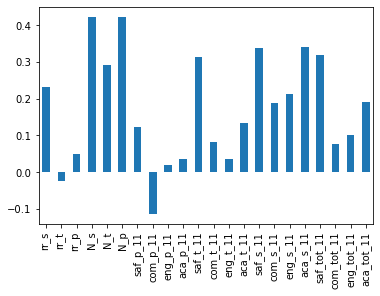

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline

combined.corr()["sat_score"][survey_fields].plot.bar()
plt.show()

There are high correlations between `N_s`, `N_t`, `N_p` and `sat_score`. Since these columns are correlated with `total_enrollment`, it makes sense that they would be high.

It is more interesting that `rr_s`, the student response rate, or the percentage of students that completed the survey, correlates with `sat_score`. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

How students and teachers percieved safety (`saf_t_11` and `saf_s_11`) correlate with sat_score. This make sense, as it's hard to teach or learn in an unsafe environment.

The last interesting correlation is the `aca_s_11`, which indicates how the student perceives academic standards, correlates with `sat_score`, but this is not true for `aca_t_11`, how teachers perceive academic standards, or `aca_p_11`, how parents perceive academic standards.

## Correlation of SAT Scores with Safety¶
We just saw there is a positive correlation between (perceived) safety and respect and SAT scores. Let's explore this further.

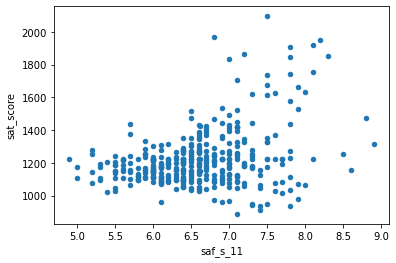

In [64]:
combined.plot.scatter("saf_s_11", "sat_score")
plt.show()

There appears to be a correlation between SAT scores and safety, although it isn't that strong. It looks like there are a few schools with extremely high SAT scores and high safety scores. There are a few schools with low safety scores and low SAT scores. No school with a safety score lower than 6.5 has an average SAT score higher than 1500 or so.

In [65]:
boros = combined.groupby("boro").agg(numpy.mean)["saf_s_11"]
print(boros)

boro
Bronx           6.607
Brooklyn        6.371
Manhattan       6.831
Queens          6.722
Staten Island   6.530
Name: saf_s_11, dtype: float64


It looks like Manhattan and Queens tend to have higher safety scores, whereas Brooklyn has low safety scores.

## Correlation of SAT scores with racial factors
Our dataset contains fields with the percentages of white, Asian, black and Hispanic students. Let's explore correlations between these and the SAT score.

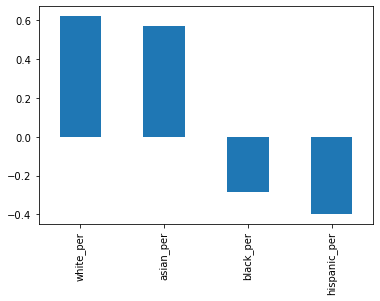

In [66]:
race_fields = ["white_per", "asian_per", "black_per", "hispanic_per"]
combined.corr()["sat_score"][race_fields].plot.bar()
plt.show()

It looks like a higher percentage of white or asian students at a school correlates positively with sat score, whereas a higher percentage of black or hispanic students correlates negatively with sat score. This may be due to a lack of funding for schools in certain areas, which are more likely to have a higher percentage of black or hispanic students.

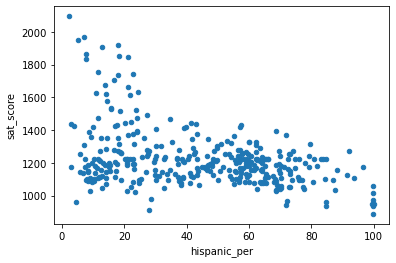

In [67]:
combined.plot.scatter("hispanic_per", "sat_score")
plt.show()

It appears as though there is slight negative correlation between them. Most of the points are bunched up between 1000 and 1400. Also, there are points where the score is higher when the hispanic population is lower, and the score is lower when the hispanic population is higher. 

In [68]:
print(combined[combined["hispanic_per"] > 95]["SCHOOL NAME"])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The schools listed above appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which would explain the lower SAT scores.

In [69]:
print(combined[combined["hispanic_per"] < 10]["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
46       HIGH SCHOOL FOR DUAL LANGUAGE AND ASIAN STUDIES
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
192                          BEDFORD ACADEMY HIGH SCHOOL
194                            BENJAMIN BANNEKER ACADEMY
220                           BOYS AND GIRLS HIGH SCHOOL
223    ACADEMY FOR COLLEGE PREPARATION AND CAREER EXP...
226               THE HIGH SCHOOL FOR GLOBAL CITIZENSHIP
227                         SCHOOL FOR HUMAN RIGHTS, THE
228                  SCHOOL FOR DEMOCRACY AND LEADERSHIP
229    HIGH SCHOOL FOR YOUTH AND COMMUNITY DEVELOPMEN...
230        HIGH SCHOOL FOR SERVICE & LEARNING AT ERASMUS
231    SCIENCE, TECHNOLOGY AND RESEARCH EARLY COLLEGE...
235              MEDGAR EVERS COLLEGE PREPARATORY SCHOOL
236                             CLARA BARTON HIGH SCHOOL
237                           IT TAKES A VILLAGE ACADEMY
238                           B

Many of the schools above appear to be specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam. This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT -- they are students from all over New York City who did well on a standardized test.

## Correlation of SAT Scores with Gender
Our dataset contains fields with the percentages of male and female students. Let's explore correlations between these and the SAT score.

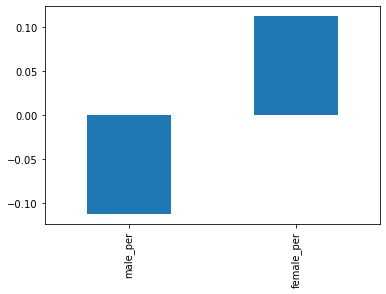

In [70]:
gender_fields = ["male_per", "female_per"]
combined.corr()["sat_score"][gender_fields].plot.bar()
plt.show()

In the plot above, we can see that a high percentage of females at a school positively correlates with SAT score, whereas a high percentage of males at a school negatively correlates with SAT score. Neither correlation is extremely strong.

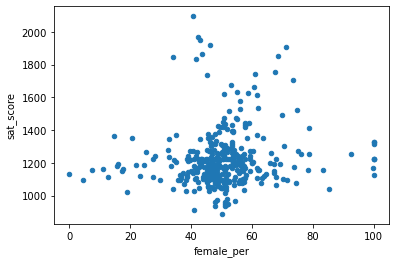

In [71]:
combined.plot.scatter("female_per", "sat_score")
plt.show()

Based on the scatterplot, there doesn't seem to be any real correlation between `sat_score` and `female_per`. However, there is a cluster of schools with a high percentage of females (60 to 80), and high SAT scores.

In [72]:
print(combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]["SCHOOL NAME"])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools appears to be very selective liberal arts schools that have high academic standards.

## AP Exam Scores vs SAT Scores

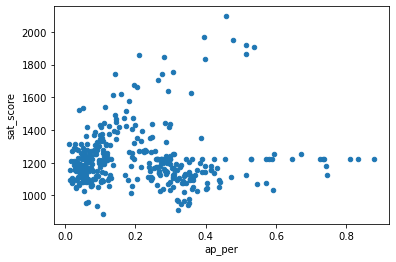

In [73]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

combined.plot.scatter(x='ap_per', y='sat_score')
plt.show()

It looks like there is a relationship between the percentage of students in a school who took the AP exam, and their average SAT scores. It's not an extremely strong correlation, though. Just to be sure, we'll calculate the exact r factor.

In [74]:
# plotting the r factor into a bar plot

combined.corr()['sat_score']['ap_per']

0.05717081390766952

Indeed an r factor almost equal to 0.

In [75]:
# dropping double columns

combined.drop(columns=['SchoolName'],inplace=True)

## Correlation between class size and SAT scores

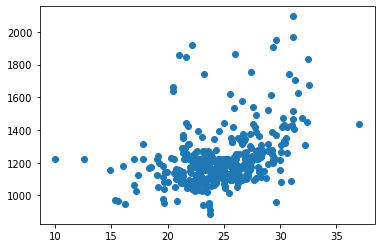

In [76]:
plt.scatter(combined['AVERAGE CLASS SIZE'], combined['sat_score'])
plt.show()

In [77]:
combined.corr()['AVERAGE CLASS SIZE']['sat_score']

0.38101433080955277

As we could imagine, the bigger the class size, there is a higher possibility that there will be higher scores in the SAT test. According to the graph, there are no schools in which the average class size is less than 20 that had scores higher than 1400.

What we're going to do now is to check which is the best neighborhood according to the average score in the SAT test.

In [78]:
## grouping the df by 'boro' column

combined.groupby('boro').agg(numpy.mean)['sat_score']

boro
Bronx           1157.598
Brooklyn        1181.364
Manhattan       1278.331
Queens          1286.753
Staten Island   1382.500
Name: sat_score, dtype: float64

The neighborhood where we can find the best schools is Staten Island.

Now we're going to establish a ranking for each school based on the results of the safety survey and the SAT scores.

In [79]:
# calculating mean for safety surveys and applying to a new column

combined['SAFETY MEAN'] = round((combined['saf_t_11'] + combined['saf_p_11'] + combined['saf_s_11']) / 3, 2)

combined['SAFETY MEAN'].value_counts(ascending=True)

6.330     1
6.400     1
5.630     1
5.800     1
6.100     1
6.270     1
5.900     1
8.200     1
9.300     1
5.930     1
8.230     1
7.540     1
8.600     1
8.670     1
8.300     1
4.930     1
5.970     1
6.030     2
6.130     2
6.430     2
6.500     2
6.700     2
8.470     2
6.230     2
8.630     2
5.600     2
8.570     2
6.730     3
8.100     3
7.170     3
7.830     3
8.500     3
8.430     3
6.770     3
8.170     3
8.070     3
7.930     4
6.530     4
8.270     4
6.800     4
6.600     4
7.700     4
7.770     4
8.330     4
7.600     4
8.400     4
7.870     4
6.930     4
6.970     4
6.300     5
7.100     5
7.670     5
6.670     5
6.370     5
7.900     6
7.800     6
8.130     6
7.130     6
8.030     6
7.970     6
6.570     6
6.900     7
7.570     7
7.200     7
7.300     7
6.870     7
7.430     7
7.500     7
7.730     8
7.270     8
7.630     8
6.630     8
7.070     8
6.830     8
7.000     9
7.030     9
7.530     9
7.330     9
7.400    10
7.470    10
7.370    10
7.230    17
Name: SAFETY MEA

In [80]:
# calculating a coefficient for ranking 

combined['K'] = round((combined['SAFETY MEAN'] * combined['sat_score']) / 100, 2)

In [81]:
combined['K'].value_counts(bins=5)

(81.172, 103.014]     179
(59.22, 81.172]       127
(103.014, 124.856]     35
(124.856, 146.698]     15
(146.698, 168.54]       7
Name: K, dtype: int64

In [82]:
# create a function returning a ranking

def ranking(x):
    if x >= 59.23 and x <= 81.172:
        return 'BB'
    elif x >= 81.173 and x <= 103.013:
        return 'BBB'
    elif x >= 103.014 and x <= 124.856:
        return 'A'
    elif x >= 124.857 and x <= 146.697:
        return 'AA'
    else:
        return 'AAA'

In [83]:
# applying function and creating new column RANKING

combined['RANKING'] = combined['K'].apply(lambda x: ranking(x))

combined['RANKING']

0       BB
1       BB
2      BBB
3      BBB
4       AA
      ... 
358     BB
359     BB
360     BB
361      A
362     BB
Name: RANKING, Length: 363, dtype: object

At this point, by adding a new dataframe, we'll analyze which borough is the best according to the quality of the schools and the cost of a residence. We'll use a dataframe found [here](https://www.kaggle.com/new-york-city/nyc-property-sales).

In [84]:
ny_sales = pd.read_csv('nyc-rolling-sales.csv')
ny_sales.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,,10009,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,,10009,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,,10009,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,,10009,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,,10009,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [85]:
ny_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Unnamed: 0                      84548 non-null  int64 
 1   BOROUGH                         84548 non-null  int64 
 2   NEIGHBORHOOD                    84548 non-null  object
 3   BUILDING CLASS CATEGORY         84548 non-null  object
 4   TAX CLASS AT PRESENT            84548 non-null  object
 5   BLOCK                           84548 non-null  int64 
 6   LOT                             84548 non-null  int64 
 7   EASE-MENT                       84548 non-null  object
 8   BUILDING CLASS AT PRESENT       84548 non-null  object
 9   ADDRESS                         84548 non-null  object
 10  APARTMENT NUMBER                84548 non-null  object
 11  ZIP CODE                        84548 non-null  int64 
 12  RESIDENTIAL UNITS               84548 non-null

First things first, we'll rename the values of the <b>BOROUGH</b> column. From digits to the values present in the combined data frame.

In [86]:
num_to_name = {1:'Manhattan',2:'Bronx',3:'Brooklyn',4:'Queens',5:'Staten Island'}

ny_sales['BOROUGH'] = ny_sales['BOROUGH'].map(num_to_name)

In [87]:
ny_sales['SALE PRICE'].value_counts()

 -         14561
0          10228
10           766
450000       427
550000       416
           ...  
1226215        1
6400           1
102900         1
2672896        1
4815000        1
Name: SALE PRICE, Length: 10008, dtype: int64

In [88]:
# replace '-' values with '0'

ny_sales['SALE PRICE'] = ny_sales['SALE PRICE'].astype(str).str.replace('-','0').astype('int64')

ny_sales[ny_sales['SALE PRICE'] <= 5000]['SALE PRICE'].value_counts()

0       24789
10        766
1         134
100        90
1000       77
500        67
5000       32
2000       14
3000        9
4000        7
2500        5
20          4
3500        4
2           3
3           2
300         1
600         1
1500        1
1275        1
315         1
1162        1
250         1
750         1
4063        1
2200        1
2510        1
3001        1
1110        1
200         1
8           1
2096        1
2352        1
2400        1
2800        1
210         1
19          1
5           1
373         1
501         1
3012        1
4500        1
4900        1
1200        1
1175        1
3750        1
3774        1
Name: SALE PRICE, dtype: int64

By analyzing the <b>SALE PRICE</b> column, we notice that many sales occur with a nonsensical small dollar amount, $0 most commonly. These sales are actually transfers of deeds between parties. For example, parents transferring ownership of their home to a child after moving out for retirement.

The sale price is a key value for our search and also because there is a large number of values that hold these unrealistic prices, we cannot simply drop those rows. We'll, instead, replace those values with the mean.

We'll replace all the values lower than $5000

In [89]:
# calculating mean price for values higher than 5000

mean_price = round(ny_sales[ny_sales['SALE PRICE'] >= 5000]['SALE PRICE'].mean(),0)

# replace values <= 5000

ny_sales['SALE PRICE'] = ny_sales['SALE PRICE'].mask(ny_sales['SALE PRICE'] <= 5000, mean_price)

Text(0.5, 1.0, 'Mean prices for borough')

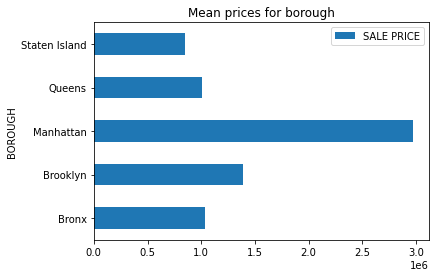

In [90]:
pivot = pd.pivot_table(ny_sales, values='SALE PRICE', index='BOROUGH').plot(kind='barh')
plt.title('Mean prices for borough')

We can see that Manhattan is the most expensive borough. The other four share more or less the same range of price. What we'll do now is find which borough has the best schools and is the most economic for buying a home. First, we're going to reduce the first dataframe to the columns that are significant for our analysis and add to it a new column <b>MEAN PRICE</b>.

In [91]:
# reducing first df

combined_final = combined[['DBN','SCHOOL NAME','boro','Num of SAT Test Takers',
       'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score', 'sat_score','bus', 'subway','Location 1', 'lat',
       'lon', 'SAFETY MEAN','RANKING']].copy()

# rename boro column to BOROUGH

combined_final.rename(columns={'boro':'BOROUGH'},inplace=True)

# create a function to calculate mean price 

def mean_price(b):
        if b == 'Manhattan':
            return round(ny_sales[ny_sales['BOROUGH'] == 'Manhattan']['SALE PRICE'].mean(), 0)
        elif b == 'Bronx':
            return round(ny_sales[ny_sales['BOROUGH'] == 'Bronx']['SALE PRICE'].mean(), 0)
        elif b == 'Brooklyn':
            return round(ny_sales[ny_sales['BOROUGH'] == 'Brooklyn']['SALE PRICE'].mean(), 0)
        elif b == 'Queens':
            return round(ny_sales[ny_sales['BOROUGH'] == 'Queens']['SALE PRICE'].mean(), 0)
        else:
            return round(ny_sales[ny_sales['BOROUGH'] == 'Staten Island']['SALE PRICE'].mean(), 0)

In [92]:
combined_final['MEAN PRICE'] = combined_final['BOROUGH'].apply(lambda x: mean_price(x))

In [93]:
manhattan = combined_final[combined_final['BOROUGH'] == 'Manhattan']['RANKING'].value_counts()
bronx = combined_final[combined_final['BOROUGH'] == 'Bronx']['RANKING'].value_counts()
brooklyn = combined_final[combined_final['BOROUGH'] == 'Brooklyn']['RANKING'].value_counts()
queens = combined_final[combined_final['BOROUGH'] == 'Queens']['RANKING'].value_counts()
staten_island = combined_final[combined_final['BOROUGH'] == 'Staten Island']['RANKING'].value_counts()

Text(0.5, 1.0, 'Mean price for borough')

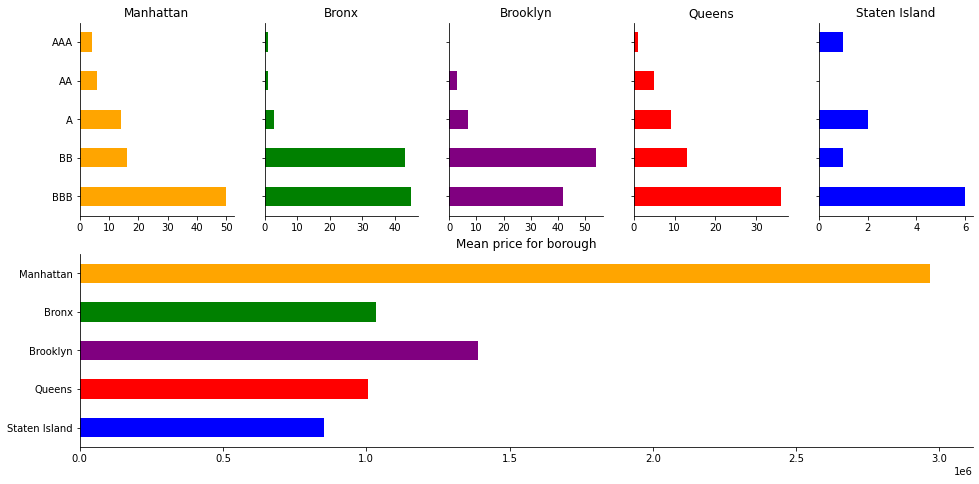

In [94]:
# plotting barh for ranking and boroughs

fig = plt.figure(figsize=(16,7.8))
ax1 = plt.subplot(2,5,1)
ax2 = plt.subplot(2,5,2)
ax3 = plt.subplot(2,5,3)
ax4 = plt.subplot(2,5,4)
ax5 = plt.subplot(2,5,5)
ax6 = plt.subplot(2,1,2)

# adding 'AAA' values for brooklyn and 'AA' values for staten island

brooklyn['AAA'] = 0
staten_island['AA'] = 0

# reindexing

brooklyn = brooklyn.reindex(['BBB','BB','A','AA','AAA'])
staten_island = staten_island.reindex(['BBB','BB','A','AA','AAA'])

axes = [ax1,ax2,ax3,ax4,ax5,ax6]

for ax in axes[:3]:
    ax.set_xticks([0,10,20,30,40,50])
    
# Hide the right and top spines

for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  

manhattan.plot(kind='barh',ax=ax1,color='orange')
ax1.set_title('Manhattan')

bronx.plot(kind='barh',ax=ax2,color='green')
ax2.set_title('Bronx')
ax2.set_yticklabels(' '*5)

brooklyn.plot(kind='barh',ax=ax3,color='purple')
ax3.set_title('Brooklyn')
ax3.set_yticklabels(' '*5)

queens.plot(kind='barh',ax=ax4,color='red')
ax4.set_title('Queens')
ax4.set_yticklabels(' '*5)

staten_island.plot(kind='barh',ax=ax5,color='blue')
ax5.set_title('Staten Island')
ax5.set_yticklabels(' '*5)

# plotting barh for mean price for borough

borough_means = pd.Series(
                          data=[mean_price(b) for b in ny_sales['BOROUGH'].unique()], 
                          index=[b for b in ny_sales['BOROUGH'].unique()]
                         )

borough_means.iloc[::-1].plot(kind='barh',ax=ax6, color=['blue', 'red', 'purple', 'green', 'orange'])
ax6.set_title('Mean price for borough')

# Conclusions

In this project we analyzed if there is any kind of correlation among scores in the SAT tests and various factors.

* Percentage of latinx students
* Safety of the school
* Percentage of female students
* Class size

We found an inverse correlation for the first factor and direct correlations for the other three. However, the correlations are not particularly strong.

In the second part of the project, we ranked each school to find which borough has the best school according to both <b>quality of the schools</b> and <b>affordability</b>.

We found out that, most likely, <b>Queens</b> is the best borough, because it has

* 1 school ranked AAA
* 5 ranked AA
* 9 ranked A

and has the most affordable prices for houses.